In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [2]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

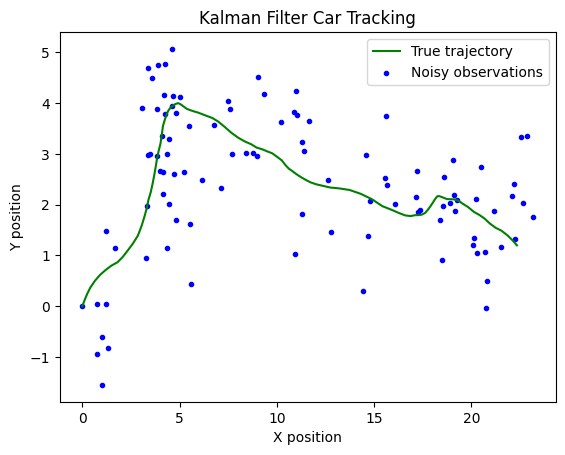

In [3]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

In [4]:
from filterpy.kalman.sigma_points import MerweScaledSigmaPoints 

In [14]:
from scipy.stats import multivariate_normal as mvn
D = mvn([0,0], R).rvs(1000)


In [41]:
sigma = MerweScaledSigmaPoints(2, alpha=0.1, beta=2., kappa=1.)
Wm, Wc = sigma.Wm, sigma.Wc
sigmas = sigma.sigma_points([0,0], [[1,0],[0,1]])

In [42]:
np.dot(Wm, sigmas)

array([0., 0.])

In [ ]:
x = np.dot(Wm, sigmas)
y = sigmas - x[np.newaxis, :]
P = np.dot(y.T, np.dot(np.diag(Wc), y))

if noise_cov is not None:
    P += noise_cov

return (x, P)

In [28]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

In [ ]:
UKF()

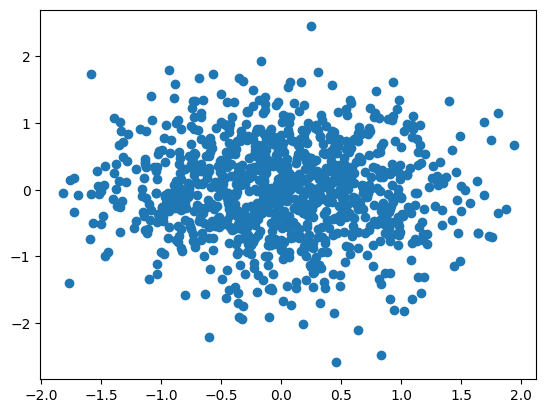

In [13]:
plt.scatter(*D.T)

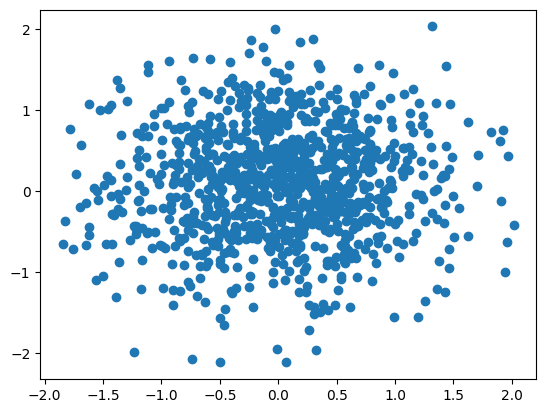